In [1]:
# Append the parent directory to the path
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

# Import base packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.linear_model import LinearRegression, Lasso
from statsmodels.regression.linear_model import OLS
import pickle
from tqdm import tqdm

In [2]:
# Import custom classes and functions
from environments.base import BaseEnvironment, SimpleBilateralEnvironment
from environments.contextual import ContextualEnvironment, OrderBookEnvironment 
from learners.experts import GFTMax, ContextualGFTMax, EDLV
from utils.regret import compute_scaling_laws, compute_scaling_laws_with_policy_regret
from utils.valuations import construct_sequence_with_lipschitz_valuations, construct_logarithmic_lower_bound

# Bilateral trade with experts - base setting

In [11]:
T = 100000 # Best expert over 100 Million turns is computed in less than a minute
env = SimpleBilateralEnvironment(T)
print(env.get_best_expert())

((0.75, 1.0), 12579.5)


In [15]:
T = 100000
env = SimpleBilateralEnvironment(T)
learner = GFTMax(T, env)
learner.run()

print(learner.get_final_gft())
print(env.get_best_expert()[1])

12276.75
12506.75


In [ ]:
time = np.linspace(1000, 100000, 20)

# Define the function in the global scope
def compute_regret():
    _, _, regret = compute_scaling_laws(GFTMax, SimpleBilateralEnvironment, time)
    return regret

num_iterations = 100
regrets = Parallel(n_jobs=-1)(delayed(compute_regret)() for _ in range(num_iterations))

In [93]:
# with open('../data/gftmax_regrets.pkl', 'wb') as f:
#     pickle.dump(regrets, f)
# with open('../data/gftmax_regrets.pkl', 'rb') as f:
#     regrets = pickle.load(f)

In [28]:
upper_bound = np.percentile(regrets, 97.5, axis=0)
lower_bound = np.percentile(regrets, 2.5, axis=0)
mean = np.mean(regrets, axis=0)

In [74]:
y = np.hstack(regrets)
X = np.tile(np.linspace(1000, 100000, 20, dtype=int), num_iterations)
X_sqrt = np.sqrt(X).reshape(-1, 1)

reg = LinearRegression().fit(X_sqrt, y)
print(f"R^2: {reg.score(X_sqrt, y)}")
print(f"Coefficient: {reg.coef_[0]}")
print(f"Intercept: {reg.intercept_}")

R^2: 0.8042409249001073
Coefficient: 0.7826947740212187
Intercept: 12.557676497467071


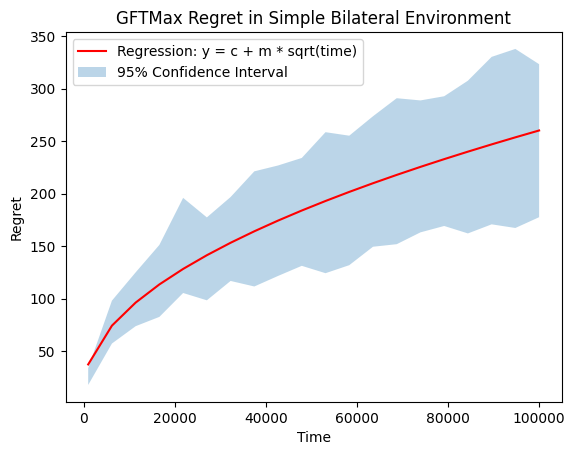

In [91]:
# Plot the regrets
plt.figure()
plt.plot(time, reg.predict(X_sqrt[:20]), label='Regression: y = c + m * sqrt(time)', color='red')
plt.fill_between(time, upper_bound, lower_bound, alpha=0.3, label='95% Confidence Interval')
plt.xlabel('Time')
plt.ylabel('Regret')
plt.title('GFTMax Regret in Simple Bilateral Environment')
plt.legend()
plt.show()

# Bilateral trade with experts - contextual setting

## Sinusoidal valuations

In [8]:
T = 100000
order_book, valuation_sequence = construct_sequence_with_lipschitz_valuations(T, Lipschitz_constant=10)
env = OrderBookEnvironment(T, order_book, valuation_sequence)
print(env.get_policy_gft_having_adhoc_valuations())

16673.824226432618


### Contextual GFTMax

This algorithm is a variation of the GFTMax algorithm: when the context does not allow to execute the sampled action, the action and all the other experts get rescaled inside the allowed limits - which are defined, again, by the context.

In [3]:
T = 100000
order_book, valuation_sequence = construct_sequence_with_lipschitz_valuations(T, Lipschitz_constant=10)
env = OrderBookEnvironment(T, order_book, valuation_sequence)
learner = ContextualGFTMax(T, env)
learner.run()

print(learner.get_final_gft())
print(env.get_policy_gft_having_adhoc_valuations())

8995.260178432756
16596.29854645664


In [15]:
time = np.linspace(1000, 100000, 10, dtype=int)
L_constants = np.linspace(5, 100, 5)

# Define the function in the global scope
def compute_regret():
    _, _, regret = compute_scaling_laws_with_policy_regret(
        ContextualGFTMax, OrderBookEnvironment, time, L_constants, 
        construct_sequence_with_lipschitz_valuations
        )
    return regret

num_iterations = 100
regrets = Parallel(n_jobs=-1)(delayed(compute_regret)() for _ in range(num_iterations))

100%|██████████| 100/100 [1:13:49<00:00, 44.30s/it]


In [16]:
# with open('../data/contextualgftmax_regrets.pkl', 'wb') as f:
#     pickle.dump(regrets, f)
# with open('../data/contextualgftmax_regrets.pkl', 'rb') as f:
#     regrets = pickle.load(f)

In [19]:
regrets = np.array(regrets)
print(regrets.shape)

(100, 10, 5)


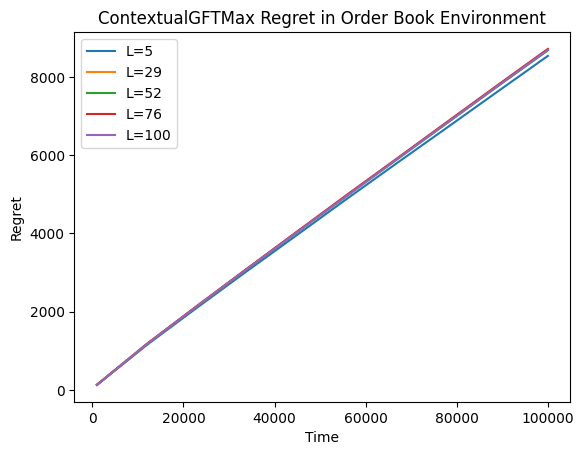

In [30]:
# Calculate the mean of each run
means = np.mean(regrets, axis=0)

# Plot the mean of the regrets per L against time
plt.figure()
for i, L in enumerate(L_constants):
    plt.plot(time, means[:, i], label=f'L={round(L)}')
plt.xlabel('Time')
plt.ylabel('Regret')
plt.title('ContextualGFTMax Regret in Order Book Environment')
plt.legend()
plt.show()

Well... this algorithm clearly does not work.

### Estimate Deterministic Lipschitz valuations

In [33]:
T = 100000
order_book, valuation_sequence = construct_sequence_with_lipschitz_valuations(T, Lipschitz_constant=10)
env = OrderBookEnvironment(T, order_book, valuation_sequence)
learner = EDLV(T, env, L=10)
learner.run()

print(learner.get_final_gft())
print(env.get_policy_gft_having_adhoc_valuations())

100%|██████████| 99999/99999 [01:51<00:00, 893.39it/s] 

16664.165120040012
16668.65212420037


A more promising start. But the algorithm is really slow. We reduce the supremum on the time horizon set from 10^5 to 10^4.

In [ ]:
time = np.logspace(start=1, stop=4, num=10, base=10, dtype=int)
L_lin1 = np.linspace(10, 500, 10, dtype=int, endpoint=False)
L_lin2 = np.linspace(500, 1000, 3, dtype=int)
L_constants = np.concatenate((L_lin1, L_lin2))

# Define the function in the global scope
def compute_regret():
    _, _, regret = compute_scaling_laws_with_policy_regret(
        EDLV, OrderBookEnvironment, time, L_constants, 
        construct_sequence_with_lipschitz_valuations
        )
    return regret

num_iterations = 100
regrets = Parallel(n_jobs=-1)(delayed(compute_regret)() for _ in range(num_iterations))

In [281]:
# with open('../data/edlv_regrets3.pkl', 'wb') as f:
#     pickle.dump(regrets, f)
# with open('../data/edlv_regrets3.pkl', 'rb') as f:
#     regrets = pickle.load(f)

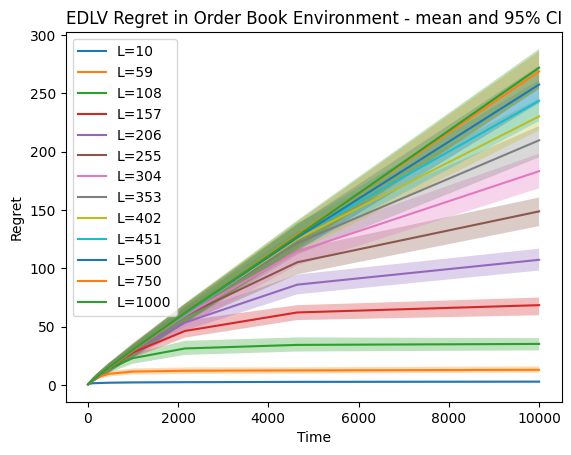

In [283]:
# Calculate the mean of each run
means = np.mean(regrets, axis=0)
# Calculate the 95% confidence interval
upper_bound = np.percentile(regrets, 97.5, axis=0)
lower_bound = np.percentile(regrets, 2.5, axis=0)

# Plot the mean of the regrets per L against time
plt.figure()
for i, L in enumerate(L_constants):
    plt.plot(time, means[:, i], label=f'L={round(L)}')
    plt.fill_between(time, upper_bound[:, i], lower_bound[:, i], alpha=0.3)
plt.xlabel('Time')
plt.ylabel('Regret')
plt.title('EDLV Regret in Order Book Environment - mean and 95% CI')
plt.legend()
plt.show()

In [284]:
# Fit regression for L=10
y = regrets[:, :, 0].reshape(-1, 1)
X = np.tile(time, num_iterations).reshape(-1, 1)
X_log = np.log(X)
X_sqrt = np.sqrt(X)
X1 = np.hstack([X, X_log])
X2 = np.hstack([X, X_log, X_sqrt])

reg = LinearRegression().fit(X1, y)
print(f"Regression with time and log(time)")
print(f"R^2: {round(reg.score(X1, y), 2)}")
for i, coef in enumerate(["time", "log(time)"]):
    print(f"Coefficient for {coef}: {round(reg.coef_[0][i], 2)}")
print(f"Intercept: {round(reg.intercept_[0], 2)}\n")

reg = LinearRegression().fit(X2, y)
print(f"Regression with time, log(time) and sqrt(time)")
print(f"R^2: {round(reg.score(X2, y), 2)}")
for i, coef in enumerate(["time", "log(time)", "sqrt(time)"]):
    print(f"Coefficient for {coef}: {round(reg.coef_[0][i], 2)}")
print(f"Intercept: {round(reg.intercept_[0], 2)}")


Regression with time and log(time)
R^2: 0.82
Coefficient for time: -0.0
Coefficient for log(time): 0.37
Intercept: -0.18

Regression with time, log(time) and sqrt(time)
R^2: 0.82
Coefficient for time: 0.0
Coefficient for log(time): 0.42
Coefficient for sqrt(time): -0.01
Intercept: -0.3


It appears that the complexity of the algorithm is the following: 
- for small values of L, the order is O(log(T)) - regression results;
- for L >= T the order is O(T) - graph.

In [316]:
# Regress the regrets onto time and Lipschitz constant

# Create a meshgrid of time and L_constants
x_mesh = np.meshgrid(L_constants, time)
X = np.stack([x_mesh[0], x_mesh[1]], axis=2)
X = np.tile(X, (num_iterations, 1, 1, 1))

# Delete the rows where L >= time
# mask = X[:, :, :, 0] < X[:, :, :, 1]

# Introduce interaction terms
# X_inter = X[:, :, :, 0] * X[:, :, :, 1]
# X = np.concatenate([X, np.expand_dims(X_inter, -1)], axis=3)

# Take the log, sqrt, power of two of the features
X_log = np.log(X)
X_sqrt = np.sqrt(X)
X_sq = X[:, :, :, 0, np.newaxis] ** 2
X = np.concatenate([X, X_log, X_sqrt, X_sq], axis=3)

# Add L/log(T), L*log(T), L*T, L*sqr(T), sqrt(L)*T
X = np.concatenate([X, (X[:, :, :, 0, np.newaxis] / np.log(X[:, :, :, 1, np.newaxis]))], axis=3)
X = np.concatenate([X, (X[:, :, :, 0, np.newaxis] * np.log(X[:, :, :, 1, np.newaxis]))], axis=3)
X = np.concatenate([X, (X[:, :, :, 0, np.newaxis] * X[:, :, :, 1, np.newaxis])], axis=3)
X = np.concatenate([X, (X[:, :, :, 0, np.newaxis] * np.sqrt(X[:, :, :, 1, np.newaxis]))], axis=3)
X = np.concatenate([X, (np.sqrt(X[:, :, :, 0, np.newaxis]) * X[:, :, :, 1, np.newaxis])], axis=3)

# X = X[mask]
# y = regrets[mask]
y = regrets

X = X.reshape(-1, 12)
y = y.reshape(-1)

# Remove time (idx 1)
X = X[:, ([i for i in range(12) if i != 1])]

vars = ["L", "log(L)", "log(time)", "sqrt(L)", "sqrt(time)", "L^2", "L/log(T)", "L*log(T)", "L*T", "L*sqrt(T)", "sqrt(L)*T"]
print(X.shape, y.shape)

(13000, 11) (13000,)


In [317]:
# Fit the regression - coefficients set as non-negative
reg = LinearRegression(positive=True).fit(X, y)
print(f"R^2: {round(reg.score(X, y), 2)}")
for i, coef in enumerate(vars):
    print(f"Coefficient for {coef}: {round(reg.coef_[i], 2)}")
print(f"Intercept: {round(reg.intercept_, 2)}")


R^2: 0.93
Coefficient for L: 0.0
Coefficient for log(L): 2.87
Coefficient for log(time): 1.22
Coefficient for sqrt(L): 0.0
Coefficient for sqrt(time): 0.0
Coefficient for L^2: 0.0
Coefficient for L/log(T): 0.0
Coefficient for L*log(T): 0.0
Coefficient for L*T: 0.0
Coefficient for L*sqrt(T): 0.0
Coefficient for sqrt(L)*T: 0.0
Intercept: -17.75


In [318]:
# Rescale the features and fit Lasso - coefficients set as non-negative
X = (X - X.mean(axis=0)) / X.std(axis=0)
reg = Lasso(positive=True).fit(X, y)
print(f"R^2: {round(reg.score(X, y), 2)}")
for i, coef in enumerate(vars):
    print(f"Coefficient for {coef}: {round(reg.coef_[i], 2)}")
print(f"Intercept: {round(reg.intercept_, 2)}")

R^2: 0.93
Coefficient for L: 0.0
Coefficient for log(L): 2.07
Coefficient for log(time): 1.53
Coefficient for sqrt(L): 0.0
Coefficient for sqrt(time): 0.0
Coefficient for L^2: 0.0
Coefficient for L/log(T): 0.0
Coefficient for L*log(T): 0.0
Coefficient for L*T: 0.0
Coefficient for L*sqrt(T): 2.39
Coefficient for sqrt(L)*T: 53.08
Intercept: 34.99


We leave the model discovery for another time. However, we could try a genetic algorithm. 

## Logarithmic lower bound

10.762977600097656


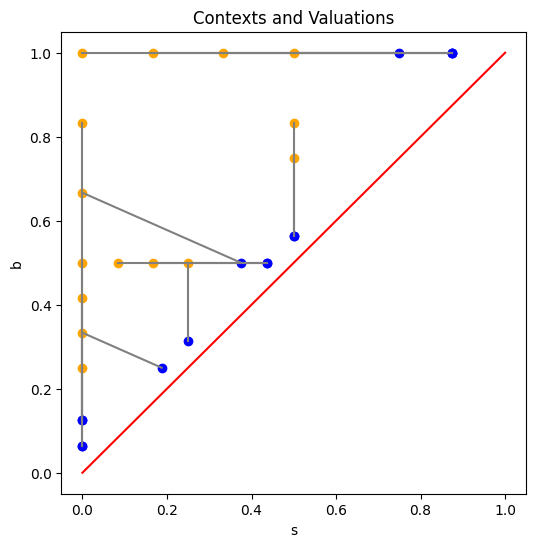

In [13]:
T = 100000
order_book, valuation_sequence = construct_logarithmic_lower_bound(T, Lipschitz_constant=10)
env = OrderBookEnvironment(T, order_book, valuation_sequence)
print(env.get_policy_gft_having_adhoc_valuations())

# Plot the first 10 elements of the valuation sequence
plt.figure(figsize=(6, 6))
plt.scatter(order_book[:15, 0], order_book[:15, 1], color="orange")
plt.scatter(valuation_sequence[:15, 0], valuation_sequence[:15, 1], color="blue")
# connect each pair of order book and valuation sequence with an arrow
for i in range(15):
    plt.plot([order_book[i, 0], valuation_sequence[i, 0]], [order_book[i, 1], valuation_sequence[i, 1]], color='grey')
plt.plot([0, 1], [0, 1], color='red')
plt.xlabel('s')
plt.ylabel('b')
plt.title('Contexts and Valuations')
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.show()

### Estimate Deterministic Lipschitz valuations

In [4]:
T = 100000
order_book, valuation_sequence = construct_logarithmic_lower_bound(T, Lipschitz_constant=10)
env = OrderBookEnvironment(T, order_book, valuation_sequence)
learner = EDLV(T, env, L=10)
learner.run()

print(learner.get_final_gft())
print(env.get_policy_gft_having_adhoc_valuations())

100%|██████████| 99999/99999 [01:39<00:00, 1004.12it/s]

2.9450836181640625
10.762977600097656


Very interestingly, even though the total Gain From Trade is 10, and in the sinusoidal function it is 16k, the regret is higher here (7>4).

In [14]:
time = np.logspace(start=1, stop=4, num=10, base=10, dtype=int)
L_lin1 = np.linspace(10, 500, 10, dtype=int, endpoint=False)
L_lin2 = np.linspace(500, 1000, 3, dtype=int)
L_constants = np.concatenate((L_lin1, L_lin2))

# Define the function in the global scope
def compute_regret():
    _, _, regret = compute_scaling_laws_with_policy_regret(
        EDLV, OrderBookEnvironment, time, L_constants, 
        construct_logarithmic_lower_bound
        )
    return regret

num_iterations = 100
regrets = Parallel(n_jobs=-1)(delayed(compute_regret)() for _ in range(num_iterations))

In [15]:
# with open('../data/edlv_log_regrets.pkl', 'wb') as f:
#     pickle.dump(regrets, f)
# with open('../data/edlv_log_regrets.pkl', 'rb') as f:
#     regrets = pickle.load(f)

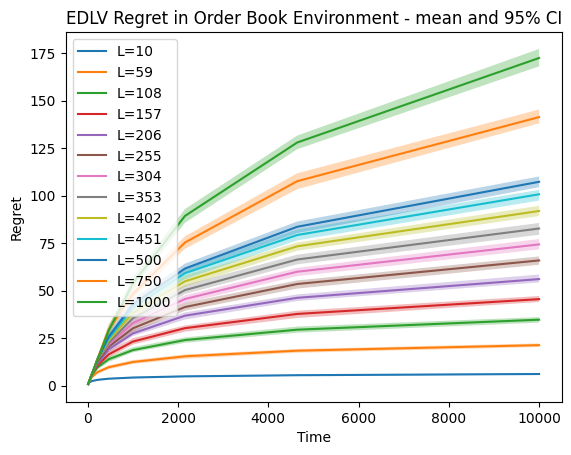

In [16]:
# Calculate the mean of each run
means = np.mean(regrets, axis=0)
# Calculate the 95% confidence interval
upper_bound = np.percentile(regrets, 97.5, axis=0)
lower_bound = np.percentile(regrets, 2.5, axis=0)

# Plot the mean of the regrets per L against time
plt.figure()
for i, L in enumerate(L_constants):
    plt.plot(time, means[:, i], label=f'L={round(L)}')
    plt.fill_between(time, upper_bound[:, i], lower_bound[:, i], alpha=0.3)
plt.xlabel('Time')
plt.ylabel('Regret')
plt.title('EDLV Regret in Order Book Environment - mean and 95% CI')
plt.legend()
plt.show()

In [20]:
regrets = np.array(regrets)
regrets.shape

(100, 10, 13)

In [21]:
# Fit regression for L=10
y = regrets[:, :, 0].reshape(-1, 1)
X = np.tile(time, num_iterations).reshape(-1, 1)
X_log = np.log(X)
X_sqrt = np.sqrt(X)
X1 = np.hstack([X, X_log])
X2 = np.hstack([X, X_log, X_sqrt])

reg = LinearRegression().fit(X1, y)
print(f"Regression with time and log(time)")
print(f"R^2: {round(reg.score(X1, y), 2)}")
for i, coef in enumerate(["time", "log(time)"]):
    print(f"Coefficient for {coef}: {round(reg.coef_[0][i], 2)}")
print(f"Intercept: {round(reg.intercept_[0], 2)}\n")

reg = LinearRegression().fit(X2, y)
print(f"Regression with time, log(time) and sqrt(time)")
print(f"R^2: {round(reg.score(X2, y), 2)}")
for i, coef in enumerate(["time", "log(time)", "sqrt(time)"]):
    print(f"Coefficient for {coef}: {round(reg.coef_[0][i], 2)}")
print(f"Intercept: {round(reg.intercept_[0], 2)}")


Regression with time and log(time)
R^2: 0.99
Coefficient for time: 0.0
Coefficient for log(time): 0.74
Intercept: -0.87

Regression with time, log(time) and sqrt(time)
R^2: 0.99
Coefficient for time: -0.0
Coefficient for log(time): 0.66
Coefficient for sqrt(time): 0.01
Intercept: -0.69


In [22]:
# Regress the regrets onto time and Lipschitz constant

# Create a meshgrid of time and L_constants
x_mesh = np.meshgrid(L_constants, time)
X = np.stack([x_mesh[0], x_mesh[1]], axis=2)
X = np.tile(X, (num_iterations, 1, 1, 1))

# Delete the rows where L >= time
# mask = X[:, :, :, 0] < X[:, :, :, 1]

# Introduce interaction terms
# X_inter = X[:, :, :, 0] * X[:, :, :, 1]
# X = np.concatenate([X, np.expand_dims(X_inter, -1)], axis=3)

# Take the log, sqrt, power of two of the features
X_log = np.log(X)
X_sqrt = np.sqrt(X)
X_sq = X[:, :, :, 0, np.newaxis] ** 2
X = np.concatenate([X, X_log, X_sqrt, X_sq], axis=3)

# Add L/log(T), L*log(T), L*T, L*sqr(T), sqrt(L)*T
X = np.concatenate([X, (X[:, :, :, 0, np.newaxis] / np.log(X[:, :, :, 1, np.newaxis]))], axis=3)
X = np.concatenate([X, (X[:, :, :, 0, np.newaxis] * np.log(X[:, :, :, 1, np.newaxis]))], axis=3)
X = np.concatenate([X, (X[:, :, :, 0, np.newaxis] * X[:, :, :, 1, np.newaxis])], axis=3)
X = np.concatenate([X, (X[:, :, :, 0, np.newaxis] * np.sqrt(X[:, :, :, 1, np.newaxis]))], axis=3)
X = np.concatenate([X, (np.sqrt(X[:, :, :, 0, np.newaxis]) * X[:, :, :, 1, np.newaxis])], axis=3)

# X = X[mask]
# y = regrets[mask]
y = regrets

X = X.reshape(-1, 12)
y = y.reshape(-1)

# Remove time (idx 1)
X = X[:, ([i for i in range(12) if i != 1])]

vars = ["L", "log(L)", "log(time)", "sqrt(L)", "sqrt(time)", "L^2", "L/log(T)", "L*log(T)", "L*T", "L*sqrt(T)", "sqrt(L)*T"]
print(X.shape, y.shape)

(13000, 11) (13000,)


In [23]:
# Fit the regression - coefficients set as non-negative
reg = LinearRegression(positive=True).fit(X, y)
print(f"R^2: {round(reg.score(X, y), 2)}")
for i, coef in enumerate(vars):
    print(f"Coefficient for {coef}: {round(reg.coef_[i], 2)}")
print(f"Intercept: {round(reg.intercept_, 2)}")

R^2: 0.97
Coefficient for L: 0.0
Coefficient for log(L): 0.71
Coefficient for log(time): 3.55
Coefficient for sqrt(L): 0.0
Coefficient for sqrt(time): 0.0
Coefficient for L^2: 0.0
Coefficient for L/log(T): 0.0
Coefficient for L*log(T): 0.0
Coefficient for L*T: 0.0
Coefficient for L*sqrt(T): 0.0
Coefficient for sqrt(L)*T: 0.0
Intercept: -16.16


In [24]:
# Rescale the features and fit Lasso - coefficients set as non-negative
X = (X - X.mean(axis=0)) / X.std(axis=0)
reg = Lasso(positive=True).fit(X, y)
print(f"R^2: {round(reg.score(X, y), 2)}")
for i, coef in enumerate(vars):
    print(f"Coefficient for {coef}: {round(reg.coef_[i], 2)}")
print(f"Intercept: {round(reg.intercept_, 2)}")

R^2: 0.97
Coefficient for L: 0.0
Coefficient for log(L): 0.0
Coefficient for log(time): 7.01
Coefficient for sqrt(L): 0.0
Coefficient for sqrt(time): 0.0
Coefficient for L^2: 0.0
Coefficient for L/log(T): 0.0
Coefficient for L*log(T): 0.0
Coefficient for L*T: 0.0
Coefficient for L*sqrt(T): 23.87
Coefficient for sqrt(L)*T: 2.4
Intercept: 25.75


# Bilateral trade with bandits - base setting

# Bilateral trade with bandits - contextual setting

In [12]:
T = 100000
contexts, valuations = construct_sequence_with_lipschitz_valuations(T, 1)
env = OrderBookEnvironment(T, contexts, valuations)
learner = ConstrainedGFTMax(T, env)
learner.run()
print(learner.hedge_profit.get_best_expert())

(array([0.52848101, 0.52848101]), 8835.178882776556)


In [13]:
T = 100000
contexts, valuations = construct_sequence_with_lipschitz_valuations(T, 10)
env = OrderBookEnvironment(T, contexts, valuations)
learner = ConstrainedGFTMax(T, env)
learner.run()
print(learner.hedge_profit.get_best_expert())

(array([0.47468354, 0.47468354]), 9582.670809600855)


In [14]:
T = 100000
contexts, valuations = construct_sequence_with_lipschitz_valuations(T, 100)
env = OrderBookEnvironment(T, contexts, valuations)
learner = ConstrainedGFTMax(T, env)
learner.run()
print(learner.hedge_profit.get_best_expert())

(array([0.50316456, 0.50316456]), 8378.397958655349)


Always guessing in the middle. Makes sense since the function is sinusoidal and the center is almost always included, hence the low regret. 

In [12]:
T = 10000
L = 1000
contexts, valuations = construct_sequence_with_lipschitz_valuations(T, L)
env = OrderBookEnvironment(T, contexts, valuations)
learner = EstimateDeterministicLipschitzValuations(T, env, L)
learner.run()
print(learner.gft)
print(env.get_policy_gft_having_adhoc_valuations())

100%|██████████| 9999/9999 [00:01<00:00, 7712.05it/s] 

1386.8119934914805
1654.4983456945142


In [13]:
T = 10000
L = 100
contexts, valuations = construct_sequence_with_lipschitz_valuations(T, L)
env = OrderBookEnvironment(T, contexts, valuations)
learner = EstimateDeterministicLipschitzValuations(T, env, L)
learner.run()
print(learner.gft)
print(env.get_policy_gft_having_adhoc_valuations())

100%|██████████| 9999/9999 [00:01<00:00, 7405.24it/s] 

1611.5774259673124
1643.9840166329484


In [12]:
T = 100
L = 100
contexts, valuations = construct_sequence_with_lipschitz_valuations(T, L)
env = OrderBookEnvironment(T, contexts, valuations)
learner = EstimateDeterministicLipschitzValuations(T, env, L)
learner.run()
print(learner.gft)
print(env.get_policy_gft_having_adhoc_valuations())

100%|██████████| 99/99 [00:00<00:00, 15084.14it/s]

12.218094988400027
16.550634895060956


In [13]:
T = 1000
L = 100
contexts, valuations = construct_sequence_with_lipschitz_valuations(T, L)
env = OrderBookEnvironment(T, contexts, valuations)
learner = EstimateDeterministicLipschitzValuations(T, env, L)
learner.run()
print(learner.gft)
print(env.get_policy_gft_having_adhoc_valuations())

100%|██████████| 999/999 [00:00<00:00, 19969.26it/s]

145.73663077802138
167.13535562559366


In [14]:
T = 10000
L = 100
contexts, valuations = construct_sequence_with_lipschitz_valuations(T, L)
env = OrderBookEnvironment(T, contexts, valuations)
learner = EstimateDeterministicLipschitzValuations(T, env, L)
learner.run()
print(learner.gft)
print(env.get_policy_gft_having_adhoc_valuations())

100%|██████████| 9999/9999 [00:01<00:00, 6381.15it/s] 

1627.8654239636578
1659.974119608851


In [15]:
T = 100000
L = 100
contexts, valuations = construct_sequence_with_lipschitz_valuations(T, L)
env = OrderBookEnvironment(T, contexts, valuations)
learner = EstimateDeterministicLipschitzValuations(T, env, L)
learner.run()
print(learner.gft)
print(env.get_policy_gft_having_adhoc_valuations())

100%|██████████| 99999/99999 [02:12<00:00, 754.72it/s] 

16687.24662213398
16721.744098935713


In [14]:
T = 10000
L = 10
contexts, valuations = construct_sequence_with_lipschitz_valuations(T, L)
env = OrderBookEnvironment(T, contexts, valuations)
learner = EstimateDeterministicLipschitzValuations(T, env, L)
learner.run()
print(learner.gft)
print(env.get_policy_gft_having_adhoc_valuations())

100%|██████████| 9999/9999 [00:01<00:00, 7402.67it/s] 

1665.1171460050782
1667.5765830394023


In [15]:
T = 10000
L = 1
contexts, valuations = construct_sequence_with_lipschitz_valuations(T, L)
env = OrderBookEnvironment(T, contexts, valuations)
learner = EstimateDeterministicLipschitzValuations(T, env, L)
learner.run()
print(learner.gft)
print(env.get_policy_gft_having_adhoc_valuations())

100%|██████████| 9999/9999 [00:01<00:00, 7587.14it/s] 

1670.8071610302575
1671.6555969135707


In [4]:
time, lipschitz_const, regret = compute_scaling_laws(EstimateDeterministicLipschitzValuations, OrderBookEnvironment, policy_regret=True, adhoc_valuations=True)

100%|██████████| 10/10 [00:13<00:00,  1.32s/it]


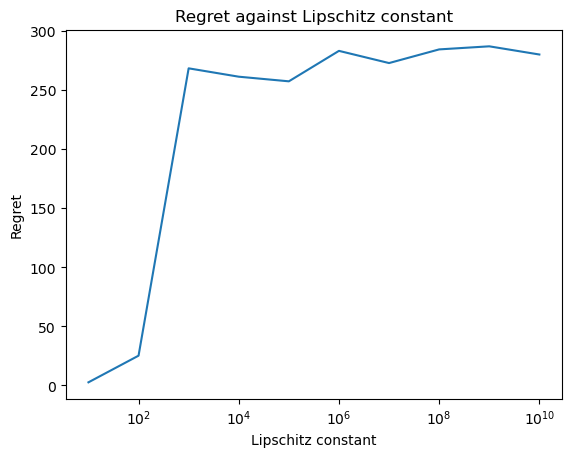

In [6]:
# Plot the regret against the Lipschitz constant (T=10000)
plt.plot(lipschitz_const, regret)
plt.xlabel('Lipschitz constant')
plt.ylabel('Regret')
plt.xscale('log')
plt.title('Regret against Lipschitz constant')
plt.show()

In [3]:
time, lipschitz_const, regret = compute_scaling_laws(EstimateDeterministicLipschitzValuations, OrderBookEnvironment, policy_regret=True, adhoc_valuations=True)

100%|██████████| 1/1 [02:10<00:00, 130.66s/it]


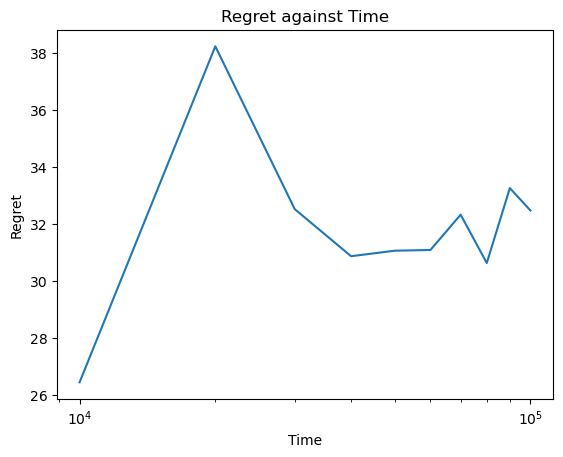

In [4]:
# Plot the regret against the time (L=100)
plt.plot(time, regret)
plt.xlabel('Time')
plt.ylabel('Regret')
plt.xscale('log')
plt.title('Regret against Time')
plt.show()

In [15]:
time, regret = compute_scaling_laws(GFTMax, DummyEnvironment)

100%|██████████| 10/10 [02:58<00:00, 17.80s/it]


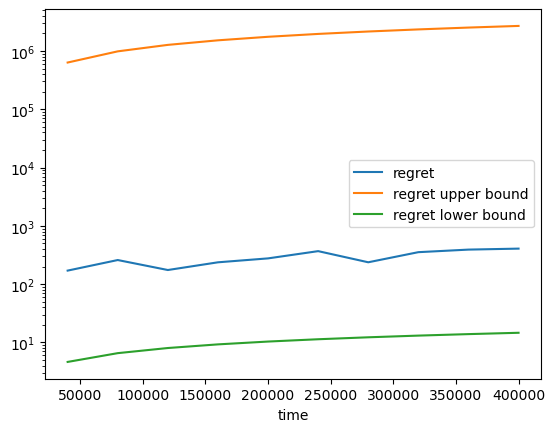

In [16]:
# Plot regret against time
df = pd.DataFrame({'time': time, 'regret': regret})
df.plot(x='time', y='regret')
# add the following equation for the upper bound: 92log^(3/2)(T)sqrt(T)
plt.plot(time, 92*np.log(time)**(3/2)*np.sqrt(time), label='regret upper bound')
# add the following equation for the lower bound: 5/216 sqrt(T)
plt.plot(time, 5/216*np.sqrt(time), label='regret lower bound')
plt.yscale('log')
plt.legend()
plt.show()

In [4]:
time, regret = compute_scaling_laws(ConstrainedGFTMax, OrderBookEnvironment, policy_regret=True)

Best expert on multiplicative grid: [0.04964539 0.04964539]. GFT: 2593.5
Best expert on multiplicative grid: [0.8 0.8]. GFT: 5619.25
Best expert on multiplicative grid: [0.04918033 0.04918033]. GFT: 8599.296875
Best expert on multiplicative grid: [0.04964539 0.04964539]. GFT: 11303.296875
Best expert on multiplicative grid: [0.79746835 0.79746835]. GFT: 14516.9375
Best expert on multiplicative grid: [0.04913295 0.04913295]. GFT: 17187.828125
Best expert on multiplicative grid: [0.04812834 0.04812834]. GFT: 20195.90625
Best expert on multiplicative grid: [0.7975 0.7975]. GFT: 23360.390625
Best expert on multiplicative grid: [0.04716981 0.04716981]. GFT: 26161.484375
Best expert on multiplicative grid: [0.04697987 0.04697987]. GFT: 29473.84375
Best expert on multiplicative grid: [0.04690832 0.04690832]. GFT: 32342.578125
Best expert on multiplicative grid: [0.79754601 0.79754601]. GFT: 35352.484375
Best expert on multiplicative grid: [0.79764244 0.79764244]. GFT: 37940.5
Best expert on m

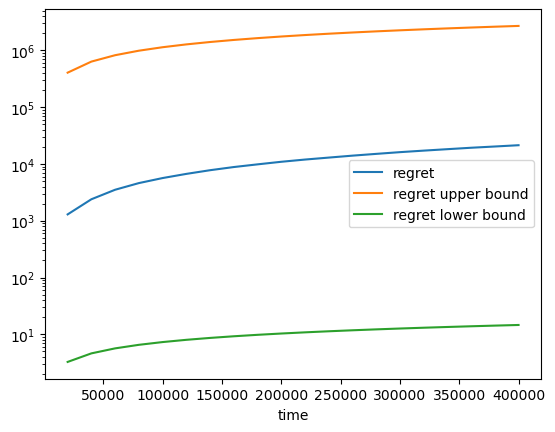

In [5]:
# Plot regret against time
df = pd.DataFrame({'time': time, 'regret': regret})
df.plot(x='time', y='regret')
# add the following equation for the upper bound: 92log^(3/2)(T)sqrt(T)
plt.plot(time, 92*np.log(time)**(3/2)*np.sqrt(time), label='regret upper bound')
# add the following equation for the lower bound: 5/216 sqrt(T)
plt.plot(time, 5/216*np.sqrt(time), label='regret lower bound')
plt.yscale('log')
plt.legend()
plt.show()

In [3]:
time, regret = compute_scaling_laws(ConstrainedGFTMax, OrderBookEnvironment, policy_regret=True, adhoc_valuations=True)

100%|██████████| 10/10 [03:16<00:00, 19.69s/it]


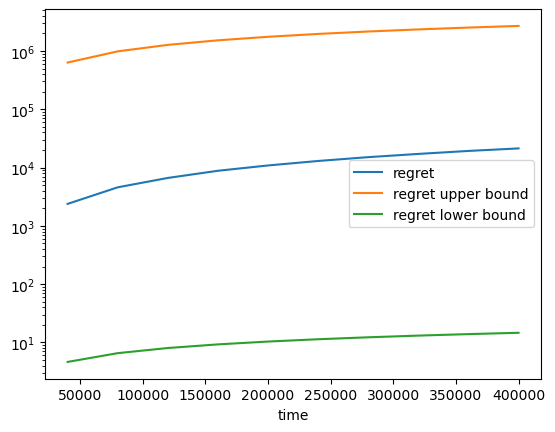

In [4]:
# Plot regret against time
df = pd.DataFrame({'time': time, 'regret': regret})
df.plot(x='time', y='regret')
# add the following equation for the upper bound: 92log^(3/2)(T)sqrt(T)
plt.plot(time, 92*np.log(time)**(3/2)*np.sqrt(time), label='regret upper bound')
# add the following equation for the lower bound: 5/216 sqrt(T)
plt.plot(time, 5/216*np.sqrt(time), label='regret lower bound')
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
# Forward selection with BIC
selected_features = []
selected_feature_indices = []
for i in range(3):
    best_BIC = np.inf
    best_indices = []
    best_var = None
    for j, var in enumerate(vars):
        if var not in selected_features:
            indices = selected_feature_indices + [j]
            X_sub = X[:, indices]
            reg = OLS(y, X_sub).fit()
            BIC = reg.bic
            if BIC < best_BIC:
                best_BIC = BIC
                best_indices = indices
                best_var = var
    selected_features.append(best_var)
    selected_feature_indices = best_indices
    print(f"Selected feature: {best_var}")


# Backward elimination with BIC
prev_BIC = np.inf
while True:
    best_BIC = prev_BIC
    worst_var = None
    best_indices = None
    for i, var in enumerate(vars):
        indices = [j for j, v in enumerate(vars) if v != var]
        model = OLS(y, X[:, indices]).fit()
        BIC = model.bic
        if BIC < best_BIC:
            best_BIC = BIC
            worst_var = var
            best_indices = indices
    if best_BIC < prev_BIC:
        prev_BIC = best_BIC
        print(f"Removing {worst_var} with BIC: {best_BIC}")
        vars.remove(worst_var)
        X = X[:, best_indices]
    else:
        break